# Problem Definition

 Develop a predictive model to identify customers likely to churn (discontinue service) based on historical customer data.We’ll use a dataset from Kaggle:https://kaggle.com/datasets/blastchar/telco-customer-churn


 Context: In the telecommunications industry, customer retention is critical for maintaining revenue and profitability. Understanding which customers are at risk of churning allows companies to implement targeted retention strategies

# Data Preprocessing
(Convert data types, handle missing values, encode categorical data)

In [ ]:

import pandas as pd

# Load data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, handling any errors as NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Drop irrelevant columns
data = data.drop(['customerID'], axis=1)

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)


<ipython-input-1-9fe7653d7cc9>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


# Exploratory Data Analysis (EDA)

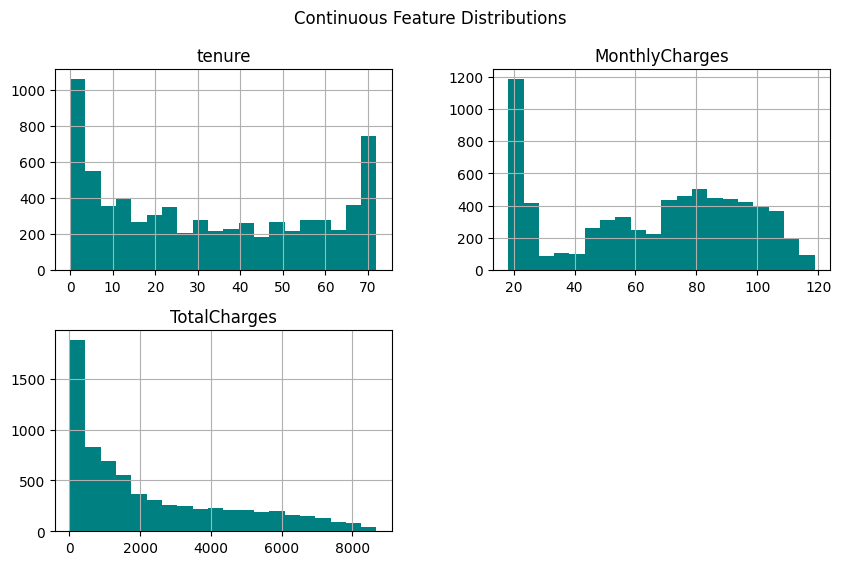

In [ ]:
# Histograms for continuous features
data_encoded[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=20, figsize=(10, 6), color='teal')
plt.suptitle('Continuous Feature Distributions')
plt.show()

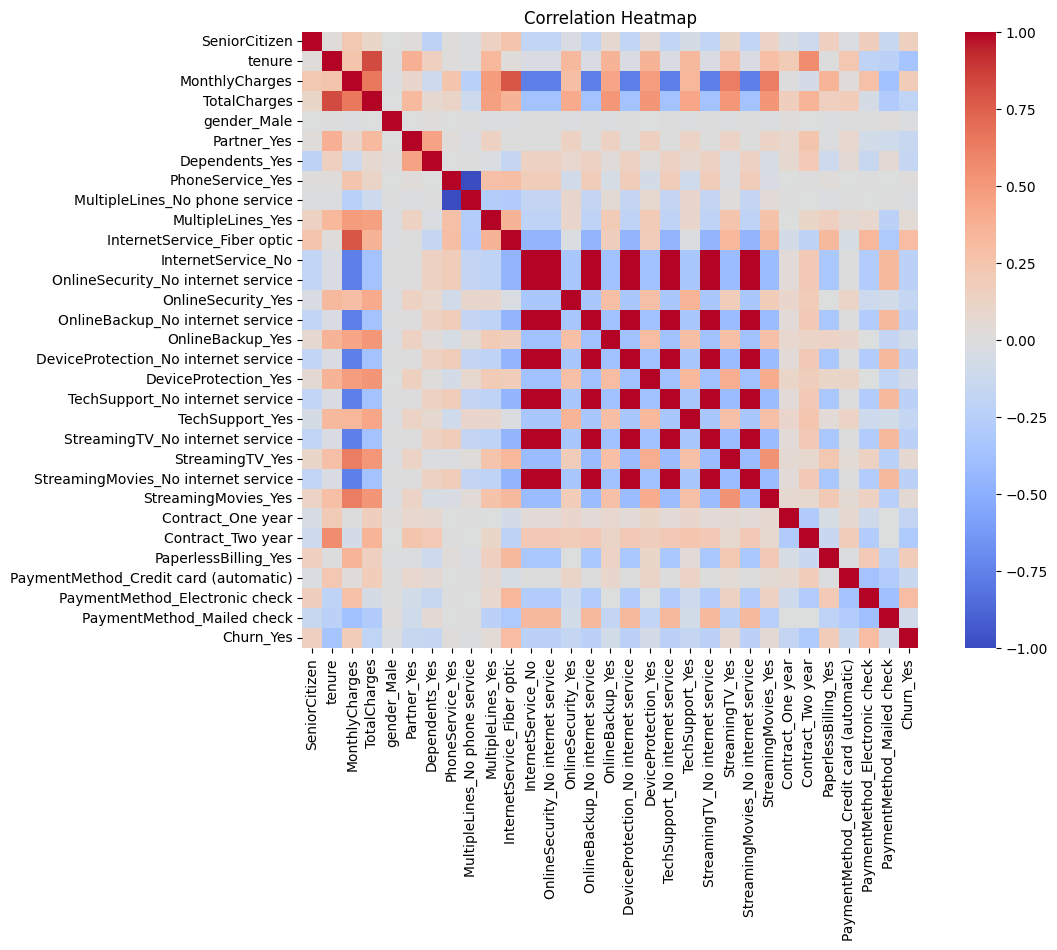

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_encoded.corr(), cmap='coolwarm', annot=False, square=True)
plt.title('Correlation Heatmap')
plt.show()

# Splitting Data
(Define feature matrix and target variable, then split into train and test sets)

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data_encoded.drop('Churn_Yes', axis=1)
y = data_encoded['Churn_Yes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training and Evaluation
(Train multiple models and compare)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=3300, random_state=42),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Initialize an empty dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        #'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Convert results to a DataFrame for easy viewing and comparison
results_df = pd.DataFrame(results).transpose()
results_df

,accuracy,recall,f1
Random Forest,0.789212,0.458445,0.535211
Logistic Regression,0.821150,0.597855,0.638968
SVM,0.735273,0.000000,0.000000
Decision Tree,0.709723,0.453083,0.452477
Gradient Boosting,0.809084,0.544236,0.601481


In [ ]:
max=0
for model_name,metrics in results.items():
  if metrics['accuracy']>max:
    max=metrics['accuracy']
    best_model=model_name
print("Best Model:",best_model)

Best Model: Logistic Regression


# Cross validation on best model

In [ ]:
from sklearn.model_selection import cross_val_score
# Select the best model based on F1 score
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print(f"{best_model_name} Cross-validated F1 score:", cv_scores.mean())


Logistic Regression Cross-validated F1 score: 0.5982259858457305


# Visualization of Model Performance

<Figure size 1200x600 with 0 Axes>

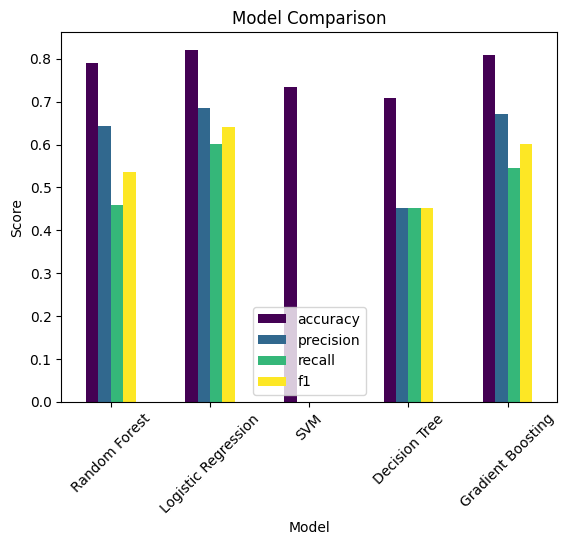

In [ ]:
import matplotlib.pyplot as plt

# Plot model performance
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', colormap='viridis', rot=45)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


# Hyperparameter Tuning (for the best model)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set parameter grid based on the chosen model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
else:
    param_grid = {}

# Only perform grid search if parameters are defined
if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
else:
    best_params = {}
    print("No hyperparameter tuning needed for", best_model_name)


No hyperparameter tuning needed for Logistic Regression


# Final Evaluation with Best Model


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions and evaluation metrics
y_pred_best = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.90      0.88      1036
        True       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409



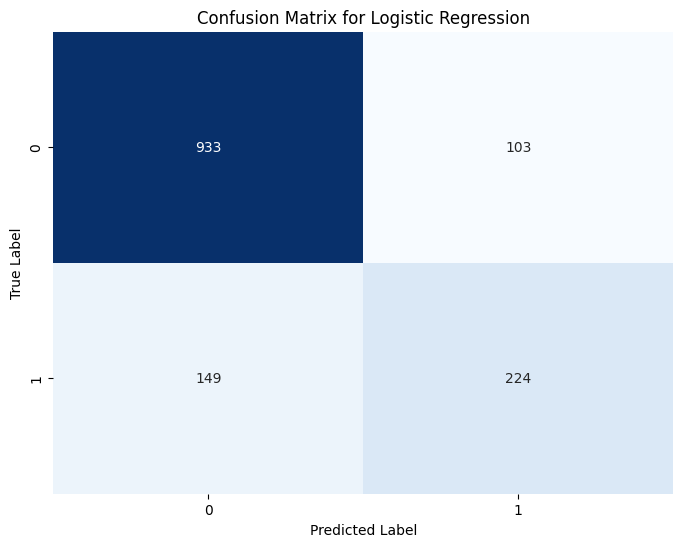

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the Model

In [ ]:
import joblib
# Save the best model
joblib.dump(best_model, 'best_churn_model.pkl')
print("Model saved as 'best_churn_model.pkl'")


Model saved as 'best_churn_model.pkl'
